In [194]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [195]:
def pseudo_function(x, x_i, n_data):
  n_wave = 5
  exp_max = 1
  exp_min = -1
  bias = 0.5
  a = 1.5

  radian_unit = (np.pi * n_wave) / n_data
  exp_unit = (exp_max - exp_min) / n_data

  y = np.sin(x_i*radian_unit) * np.exp(exp_max-(exp_unit*x_i)) + bias + a*x
  y = y+np.random.normal(loc=0, scale=0.1)

  return y

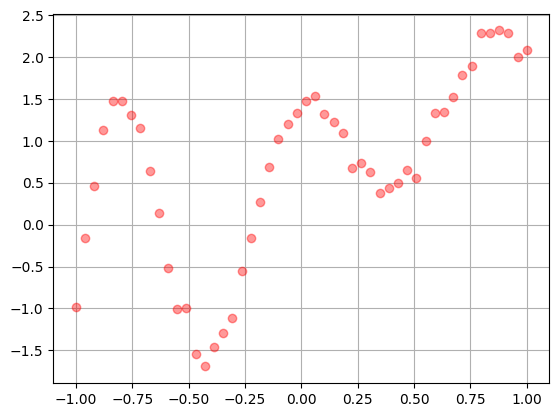

In [196]:
random.seed(123)
n_data = 50
x_range = (-1, 1)

x_all = np.linspace(-1, 1, n_data, dtype=np.float32)
y_all = np.array([pseudo_function(x,x_i,n_data) for x_i, x in enumerate(list(x_all))], dtype=np.float32)

plt.plot(x_all, y_all, 'ro', alpha=0.4)
plt.grid()

In [197]:
index_list = list(range(len(x_all)))
random.shuffle(index_list)

In [198]:
x_all, y_all = x_all[index_list], y_all[index_list]

In [199]:
train_ratio = 0.5
valid_ratio = 0.25
test_ratio = 0.25

total = len(x_all)

n_train = int(total * train_ratio)
n_valid = int(total * valid_ratio)

x_train = x_all[:n_train]
x_valid = x_all[n_train:n_train+n_valid]
x_test = x_all[n_train+n_valid:]

y_train = y_all[:n_train]
y_valid = y_all[n_train:n_train+n_valid]
y_test = y_all[n_train+n_valid:]

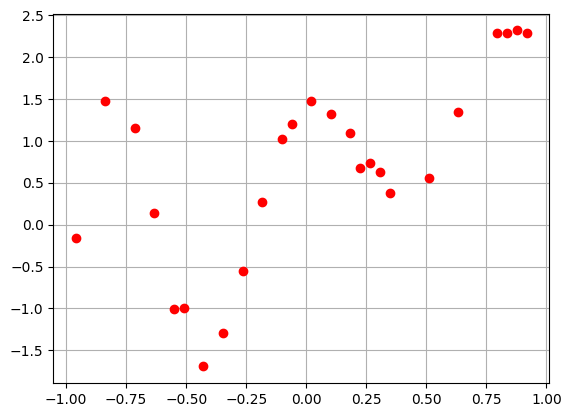

In [200]:
plt.plot(x_train, y_train, 'ro')
plt.grid()

<ipython-input-201-65e396f5c9b4>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_valid, y_valid, 'ro', color='blue')


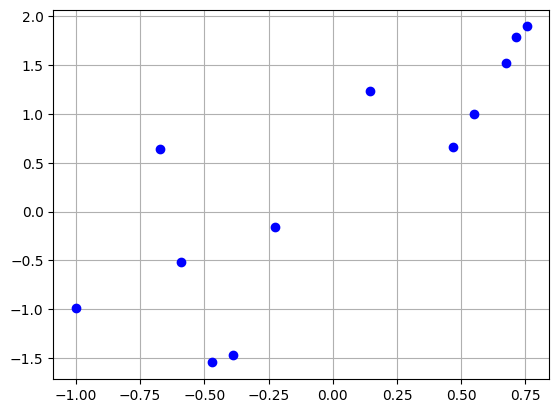

In [201]:
plt.plot(x_valid, y_valid, 'ro', color='blue')
plt.grid()

<ipython-input-202-49a566ebadfc>:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_test, y_test, 'ro', color='green')


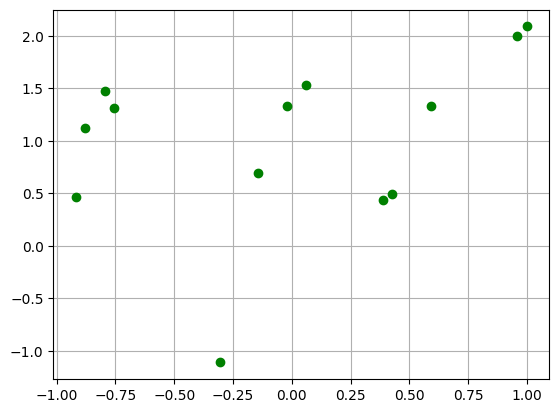

In [202]:
plt.plot(x_test, y_test, 'ro', color='green')
plt.grid()

In [203]:
import torch
from torch.utils.data import Dataset, DataLoader

In [204]:
class PseudoData(Dataset):
  def __init__(self, data_x, data_y = None):
    self.data_x = data_x.tolist()

    if data_y is not None:
      self.data_y = data_y.tolist()
    else: self.data_y = None

  def __len__(self):
    return len(self.data_x)

  def __getitem__(self, idx):
    sample = {}
    sample['x'] = self.data_x[idx]

    if self.data_y is not None:
      sample['y'] = self.data_y[idx]

    return sample

In [205]:
def collate_fn(batch):
  keys = [key for key in batch[0].keys()]
  data = {key: [] for key in keys}

  for item in batch:
    for key in keys:
      data[key].append(item[key])
  return data

In [206]:
train_dataset = PseudoData(x_train, y_train)
valid_dataset = PseudoData(x_valid, y_valid)
test_dataset = PseudoData(x_test, y_test)

train_dataloader= DataLoader(train_dataset,
                             batch_size=4,
                             collate_fn=collate_fn,
                             shuffle=True)

valid_dataloader= DataLoader(valid_dataset,
                             batch_size=4,
                             collate_fn=collate_fn,
                             shuffle=False)

test_dataloader= DataLoader(test_dataset,
                            batch_size=4,
                            collate_fn=collate_fn,
                            shuffle=False)

In [207]:
for batch in train_dataloader:
    print(batch)


{'x': [0.3469387888908386, -0.26530611515045166, -0.4285714328289032, 0.26530611515045166], 'y': [0.37308984994888306, -0.55860435962677, -1.6934759616851807, 0.7337313294410706]}
{'x': [-0.18367347121238708, -0.5510203838348389, -0.5102040767669678, 0.795918345451355], 'y': [0.27629387378692627, -1.0051920413970947, -0.9980868697166443, 2.2848923206329346]}
{'x': [-0.6326530575752258, 0.5102040767669678, 0.918367326259613, -0.10204081982374191], 'y': [0.14435753226280212, 0.5580220222473145, 2.2949225902557373, 1.0283448696136475]}
{'x': [-0.06122449040412903, -0.8367347121238708, -0.7142857313156128, 0.18367347121238708], 'y': [1.197139859199524, 1.4829548597335815, 1.1602286100387573, 1.0955519676208496]}
{'x': [0.22448979318141937, 0.020408162847161293, 0.6326530575752258, 0.30612245202064514], 'y': [0.6735168099403381, 1.482509970664978, 1.3437811136245728, 0.6241315603256226]}
{'x': [-0.3469387888908386, -0.9591836929321289, 0.8775510191917419, 0.10204081982374191], 'y': [-1.2924

In [208]:
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from copy import deepcopy

In [209]:
class MLPRegression(nn.Module):

  def __init__(self, input_dim = 1, hidden_size = 32, n_layers=2, output_dim = 1):
    super().__init__()
    self.linears = nn.ModuleList([nn.Linear(input_dim, hidden_size)] + \
                                 [nn.Linear(hidden_size, hidden_size) for i in range(n_layers-2)]+ \
                                 [nn.Linear(hidden_size, output_dim)])
    self.apply(self._init_weights)
  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      init.xavier_normal_(m.weight.data)
      init.normal_(m.bias.data)

  def forward(self, x):
    if len(x.size()) == 1:
      x = x.view(-1, 1)

      h = x
      for i, linear in enumerate(self.linears):
        h = linear(h)

        if i != len(self.linears) -1 :
          h = torch.relu(h)

      logit = h

      return logit.flatten()

In [210]:
model = MLPRegression(input_dim=1, hidden_size=32, n_layers=6, output_dim = 1)

In [211]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

In [212]:
loss_fn = nn.MSELoss()

In [213]:
n_epoch = 10000
global_i = 0

valid_loss_history = [] # [(global_i, valid_loss), ...]
train_loss_history = [] # [(global_i, train_loss), ...]

min_valid_loss = 9e+9
best_model = None
best_epoch_i = None

for epoch in range(n_epoch):
  model.train()

  for batch in train_dataloader:
    optimizer.zero_grad()
    x = torch.tensor(batch['x'])
    y = torch.tensor(batch['y'])

    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    loss.backward()
    optimizer.step()
    if global_i % 10000 == 0:
      print(f"global_i: {global_i}, epoch_i: {epoch}, loss: {loss.item()}")

    train_loss_history.append((global_i, loss.item()))

    global_i += 1

  model.eval()
  valid_loss_list = []
  for batch in valid_dataloader:
    x = torch.tensor(batch['x'])
    y = torch.tensor(batch['y'])
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    valid_loss_list.append(loss.item())

  valid_loss_mean = np.mean(valid_loss_list)
  valid_loss_history.append((global_i, valid_loss_mean.item()))

  if valid_loss_mean < min_valid_loss:
    min_valid_loss = valid_loss_mean
    best_epoch_i = epoch
    best_model = deepcopy(model)

  if epoch % 1000 == 0:
    print('*'*30)
    print(f'valid loss mean: {valid_loss_mean}')
    print('*'*30)

print(f'best_epoch_i: {best_epoch_i}')

global_i: 0, epoch_i: 0, loss: 19.808225631713867
******************************
valid loss mean: 7.412636439005534
******************************
******************************
valid loss mean: 0.02985445410013199
******************************
global_i: 10000, epoch_i: 1428, loss: 0.005506694316864014
******************************
valid loss mean: 0.061403692389527954
******************************
global_i: 20000, epoch_i: 2857, loss: 0.0012093583354726434
******************************
valid loss mean: 0.05275870238741239
******************************
******************************
valid loss mean: 0.08457429893314838
******************************
global_i: 30000, epoch_i: 4285, loss: 0.0013256333768367767
******************************
valid loss mean: 0.06761259958148003
******************************
global_i: 40000, epoch_i: 5714, loss: 0.03330511599779129
******************************
valid loss mean: 0.06391541194170713
******************************
*********************

In [214]:
def calc_moving_average(arr, win_size=100):
  new_arr = []
  win = []

  for i, val in enumerate(arr):
    win.append(val)
    if len(win) > win_size:
      win.pop(0)

    new_arr.append(np.mean(win))
  return np.array(new_arr)

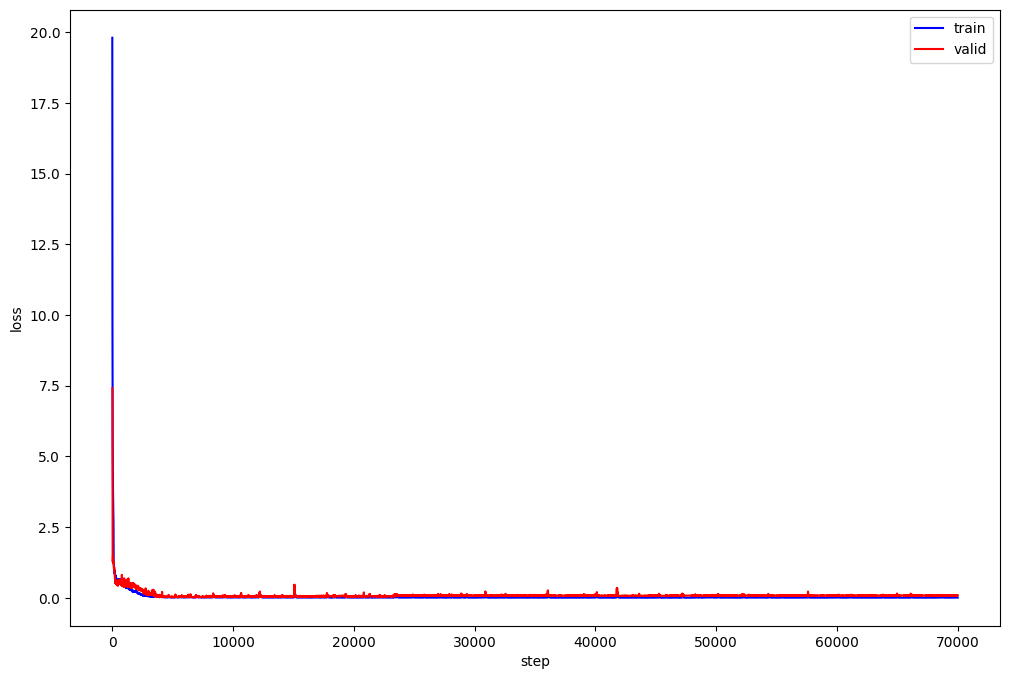

In [215]:
valid_loss_history = np.array(valid_loss_history)
train_loss_history = np.array(train_loss_history)

plt.figure(figsize=(12,8))
plt.plot(train_loss_history[:,0],
         calc_moving_average(train_loss_history[:,1]), color='blue', label="train")

plt.plot(valid_loss_history[:,0],
         valid_loss_history[:,1], color='red', label="valid")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()

In [216]:
model.eval()

test_loss_list = []
for batch in test_dataloader:
  x = torch.tensor(batch['x'])
  y = torch.tensor(batch['y'])
  y_pred = model(x)

  test_loss = loss_fn(y_pred, y)

  test_loss_list.append(test_loss.item())
test_loss_mean = np.mean(test_loss_list)
print(f'test loss: {test_loss_mean}')

test loss: 0.11821222491562366


In [217]:
n_data = 50
x_range = (-1, 1)

x_grid = np.linspace(-1, 1, n_data,dtype=np.float32)

grid_dataset = PseudoData(data_x=x_grid)
grid_dataloader= DataLoader(grid_dataset,
                            batch_size=8,
                            collate_fn=collate_fn,
                            shuffle=False)

y_pred_list = []
for batch in grid_dataloader:
    x = torch.tensor(batch['x'])
    y_pred = model(x)
    y_pred_list.extend(y_pred.detach().tolist())


<ipython-input-218-3a03356eadf4>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_train, y_train, 'ro', alpha=0.4, color='black')
<ipython-input-218-3a03356eadf4>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_valid, y_valid, 'ro', alpha=0.4, color='blue')
<ipython-input-218-3a03356eadf4>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_test, y_test, 'ro', alpha=0.4, color='red')


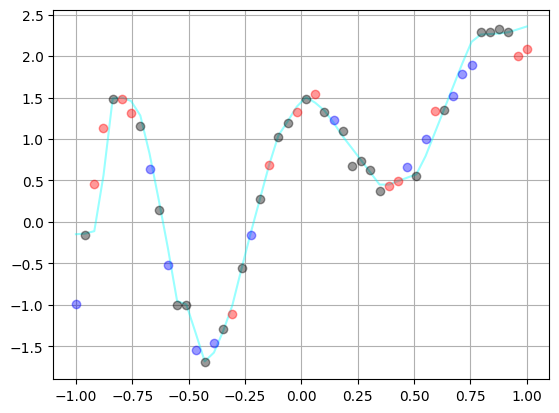

In [218]:
plt.plot(x_grid, y_pred_list, alpha=0.4, color='cyan')
plt.plot(x_train, y_train, 'ro', alpha=0.4, color='black')
plt.plot(x_valid, y_valid, 'ro', alpha=0.4, color='blue')
plt.plot(x_test, y_test, 'ro', alpha=0.4, color='red')
plt.grid()